In [1]:
import torch
import csv
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset    
from torch.utils.data import DataLoader
import torch.nn as nn

from sklearn.utils import class_weight
from sklearn import metrics

DATASET = 'cryptobench'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'
DISTANCE_MATRICES_PATH = f'{DATA_PATH}/distance-matrices'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
POSITIVE_DISTANCE_THRESHOLD = 15
NEGATIVE_DISTANCE_THRESHOLD = 10

def process_sequence_dataset(annotation_path, embeddings_path, distance_matrices_path, perform_assertions=True):
    Xs = {}
    Ys = {}
    idx = {}

    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            if perform_assertions:
                sequence = row[4]

            if row[3] == '':
                continue
            
            assert id not in Xs
            assert id not in Ys
            Xs[id] = []
            Ys[id] = []
            idx[id] = []

            # load the precomputed embedding
            filename = id + '.npy'
            embedding = np.load(f'{embeddings_path}/{filename}')
            
            # load the distance matrix
            distance_matrix = np.load(f'{distance_matrices_path}/{id}.npy')

            negative_examples_indices = set()
            binding_residues_indices = [int(residue[1:]) for residue in row[3].split(' ')]
            
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                if perform_assertions:
                    assert sequence[residue_idx] == aa
                # check if the distance of the residue to all other residues is less than the threshold
                close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
                # get residues that are close to the current residue and are binding residues
                close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)
                
                # create embedding by aggregating the embeddings of the close binding residues
                concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
                Xs[id].append(concatenated_embedding)
                Ys[id].append(1) # positive example
                idx[id].append(residue_idx)
                
                # Let's get negative examples:
                # add those that are really close to the binding residues (i.e. within NEGATIVE_DISTANCE_THRESHOLD) but are not binding residues
                really_close_residues_indices = np.where(distance_matrix[residue_idx] < NEGATIVE_DISTANCE_THRESHOLD)[0]
                # add non-binding residues to the list of negatives (that's the exclusive left join of really_close_residues_indices and binding_residues_indices)
                negative_examples_indices.update(set(list(really_close_residues_indices)) - set(list(binding_residues_indices)))

            # add negative examples - create the embeddings 
            for residue_idx in negative_examples_indices:
                close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
                close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)

                # create embedding 
                concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
                Xs[id].append(concatenated_embedding)
                Ys[id].append(0) # negative example
                idx[id].append(residue_idx)

    return Xs, Ys, idx

class SmoothnessClassifierDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        _Xs_list = []
        _Ys_list = []

        for key, _ in _Xs.items():
            # print(f'Processing {key} ...')
            _Xs_list.append(_Xs[key])
            _Ys_list.append(_Ys[key])

        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_list = np.concatenate(_Ys_list, axis=0)

        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y


In [3]:
Xs_train_apo, Ys_train_apo, _ = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
train_dataset_apo = SmoothnessClassifierDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo, idx_test_apo = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
test_dataset_apo = SmoothnessClassifierDataset(Xs_test_apo, Ys_test_apo)

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...


In [10]:
DECISION_THRESHOLD = 0.8
DROPOUT = 0.3
LAYER_WIDTH = 256
# ESM2_DIM = 320
# ESM2_DIM  = 1280
ESM2_DIM  = 2560 * 2

class CryptoBenchClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, bce_loss=nn.functional.binary_cross_entropy_with_logits, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # controls class imbalance
        self.gamma = gamma  # focuses on hard examples
        self.reduction = reduction
        self.bce_loss = bce_loss

    def forward(self, inputs, targets):
        # Calculate Binary Cross-Entropy Loss for each sample
        BCE_loss = self.bce_loss(inputs, targets)
        
        # Compute pt (model confidence on true class)
        pt = torch.exp(-BCE_loss)
        
        # Apply the focal adjustment
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        # Apply reduction (mean, sum, or no reduction)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        
def train(model, optimizer, epochs, batch_size, train_dataset, test_dataset):
    model = model.to(device)

    # Create an optimizer
    _, y_train = train_dataset[:]
    X_test, y_test, = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    class_weights = compute_class_weights(y_train.numpy()).to(device)
    print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=2 * class_weights[1])
    # loss_fn = FocalLoss(alpha=1, gamma=2, bce_loss=loss_fn)

    X_test, y_test = X_test.to(device), y_test.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits = model(X_test).squeeze()
            
            test_loss = loss_fn(test_logits,
                                y_test)
            test_losses.append(test_loss.cpu().detach().numpy())

            test_pred = (torch.sigmoid(test_logits)>DECISION_THRESHOLD).float()

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)
            
            fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

            f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            auprc = metrics.auc(recall, precision)


        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            model.train()

            y_logits = model(x_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(test_pred)}")

    plt.plot(train_losses,label="train loss over epochs")
    plt.plot(test_losses,label="test loss over epochs")
    plt.legend()
    plt.show()

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        test_pred = (torch.sigmoid(test_logits)>i).float()
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
        f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')
        print(f'THRESHOLD: {i} | F1: {f1:.4f} | MCC: {mcc:.4f} | Test acc: {test_acc:.2f}%')
    
    return fpr, tpr, roc_auc

Class weights:  tensor([0.6196, 2.5911], device='cuda:0')
Epoch: 0 | Loss: 1.14411, Accuracy: 81.04% | Test loss: 1.23724, AUC: 0.4832, MCC: 0.0000, F1: 0.7255, AUPRC: 0.1772, sum: 0.0
Epoch: 1 | Loss: 0.96438, Accuracy: 80.89% | Test loss: 1.10723, AUC: 0.7724, MCC: -0.0055, F1: 0.7253, AUPRC: 0.3939, sum: 35.0
Epoch: 2 | Loss: 0.90002, Accuracy: 81.39% | Test loss: 0.96548, AUC: 0.8104, MCC: 0.3060, F1: 0.7968, AUPRC: 0.4479, sum: 1995.0
Epoch: 3 | Loss: 0.87226, Accuracy: 82.57% | Test loss: 0.88986, AUC: 0.8359, MCC: 0.3704, F1: 0.8140, AUPRC: 0.5039, sum: 2252.0
Epoch: 4 | Loss: 0.86769, Accuracy: 83.36% | Test loss: 0.85326, AUC: 0.8478, MCC: 0.3980, F1: 0.8220, AUPRC: 0.5450, sum: 2225.0
Epoch: 5 | Loss: 0.76159, Accuracy: 83.76% | Test loss: 0.82934, AUC: 0.8566, MCC: 0.4414, F1: 0.8324, AUPRC: 0.5752, sum: 2680.0
Epoch: 6 | Loss: 0.76870, Accuracy: 84.22% | Test loss: 0.81434, AUC: 0.8619, MCC: 0.4546, F1: 0.8366, AUPRC: 0.5909, sum: 2636.0
Epoch: 7 | Loss: 0.69333, Accuracy: 

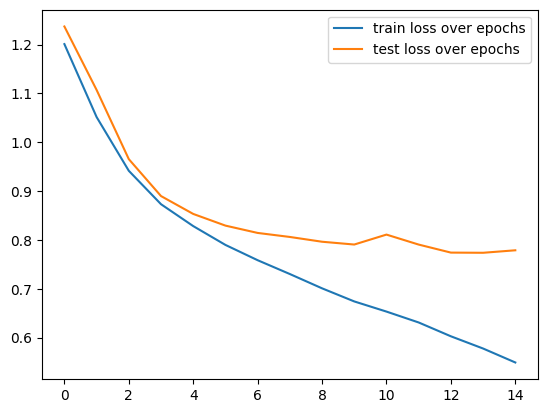

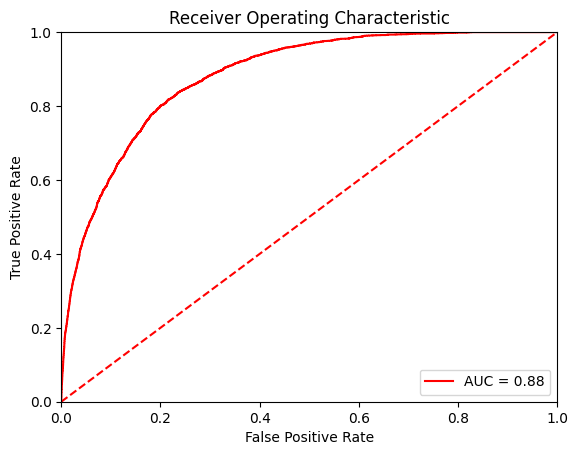

THRESHOLD: 0.1 | F1: 0.6111 | MCC: 0.3632 | Test acc: 57.32%
THRESHOLD: 0.2 | F1: 0.6876 | MCC: 0.4139 | Test acc: 65.10%
THRESHOLD: 0.3 | F1: 0.7368 | MCC: 0.4464 | Test acc: 70.49%
THRESHOLD: 0.4 | F1: 0.7740 | MCC: 0.4717 | Test acc: 74.82%
THRESHOLD: 0.5 | F1: 0.8038 | MCC: 0.4963 | Test acc: 78.43%
THRESHOLD: 0.6 | F1: 0.8274 | MCC: 0.5111 | Test acc: 81.46%
THRESHOLD: 0.7 | F1: 0.8401 | MCC: 0.5039 | Test acc: 83.44%
THRESHOLD: 0.8 | F1: 0.8485 | MCC: 0.4980 | Test acc: 85.19%
THRESHOLD: 0.9 | F1: 0.8365 | MCC: 0.4542 | Test acc: 85.52%


In [11]:
model_3 = CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=model_3.parameters(),
                            lr=0.0001)

fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=15, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

In [ ]:
# predict on the test set

def predict(Xs, Ys, idx, output_path):
    for key, _ in Xs.items():
        # print(f'Processing {key} ...')
        Xs[key] = torch.tensor(Xs[key], dtype=torch.float32).to(device)
        Ys[key] = torch.tensor(Ys[key], dtype=torch.int64).to(device)
        idx[key] = torch.tensor(idx[key], dtype=torch.int64).to(device)
    
        test_logits = model_3(Xs[key]).squeeze()
        test_pred = torch.sigmoid(test_logits)
    
        np.save(f'{output_path}/{key}.npy', {'predictions': test_pred.detach().cpu().numpy(), 'indices': idx[key].detach().cpu().numpy()})

predict(Xs_test_apo, Ys_test_apo, idx_test_apo, f'{DATA_PATH}/smoothness-prediction')

/tmp/slurm.176375/ipykernel_332101/413262741.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  Xs[key] = torch.tensor(Xs[key], dtype=torch.float32).to(device)


## Smoothen model predictions
Take predictions from the finetuned model, and smoothen them.

In [ ]:
import os

PREDICTION_THRESHOLD = 0.7 # determined using MCC score in `src/fine-tuning/manual-finetuning.ipynb`
PREDICTION_PATH = '/home/skrhakv/cryptic-nn/src/fine-tuning/predictions/ESM2-3B-extended-finetuning/predictions'
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/fine-tuning/predictions/ESM2-3B-extended-finetuning/predictions.csv'
SMOOTHENESS_PREDICTION_PATH = '/home/skrhakv/cryptic-nn/src/fine-tuning/predictions/ESM2-3B-extended-finetuning/smoothen-prediction'
def create_test_file(output_path):
    with open(output_path, 'w') as f:
        writer = csv.writer(f, delimiter=";")
        for filename in os.listdir(PREDICTION_PATH):

            protein_id = filename.split('.')[0]
            pdb_id = protein_id[:4]
            chain_id = protein_id[4:]

            predictions = (np.load(f'{PREDICTION_PATH}/{filename}') > PREDICTION_THRESHOLD).astype(int)

            writer.writerow([pdb_id, chain_id, 'UNKNOWN', ' '.join(['X' + str(idx) for idx in predictions]), 'UNKNOWN'])

create_test_file(OUTPUT_PATH)
Xs_predicted, Ys_predicted, idx_predicted = process_sequence_dataset(OUTPUT_PATH, ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH, perform_assertions=False)

predict(Xs_predicted, Ys_predicted, idx_predicted, f'{DATA_PATH}/smoothness-prediction-extended')

AssertionError: 